In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from motifs.pipeline import Pipeline
from motifs.plots import plot_motif_histogram, plot_tf_idf
from motifs.pca import pca_transform
from motifs.config import PKG_DATA_PATH
import time

# Define the path of the corpus
corpus_dir = PKG_DATA_PATH.joinpath('corpus_test')
tokens_dir = None
# tokens_dir = "../data/canon/tokens_canon"
# corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# Define the feature on which to perform PCA analysis
feature = {"name": "tfidf", "params": {"normalize": False, "smartirs": "nfc"}}
# n-gram length
n = 5

# Create pipeline object and perform annotation

In [2]:
pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)

[PyMotifs-Logger:tokenizer.py:299] - [12174] - 2024-02-20 12:19:49 - DEBUG - Steps to go 3: tokenizing Huysmans-Rebours.txt...
[PyMotifs-Logger:tokenizer.py:317] - [12174] - 2024-02-20 12:19:51 - DEBUG - Done with Huysmans-Rebours.txt in 2.22 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [12174] - 2024-02-20 12:19:51 - DEBUG - Steps to go 2: tokenizing Flaubert-Bovary.txt...
[PyMotifs-Logger:tokenizer.py:317] - [12174] - 2024-02-20 12:19:53 - DEBUG - Done with Flaubert-Bovary.txt in 2.3 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [12174] - 2024-02-20 12:19:53 - DEBUG - Steps to go 1: tokenizing Balzac-Goriot.txt...
[PyMotifs-Logger:tokenizer.py:317] - [12174] - 2024-02-20 12:19:56 - DEBUG - Done with Balzac-Goriot.txt in 2.47 seconds.


# Transform tokens to n-grams and present simple statistics

Execution time: 0.1522 secs


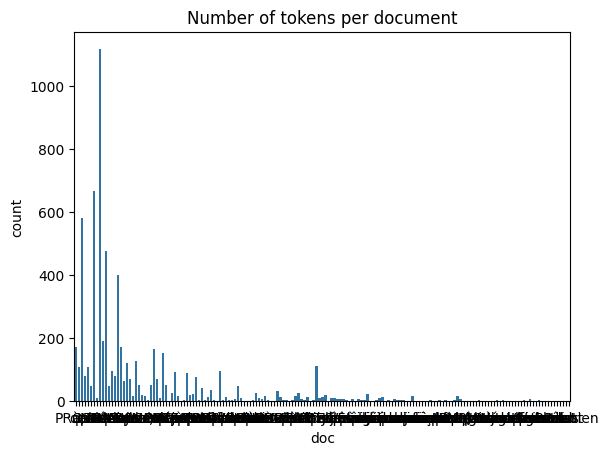

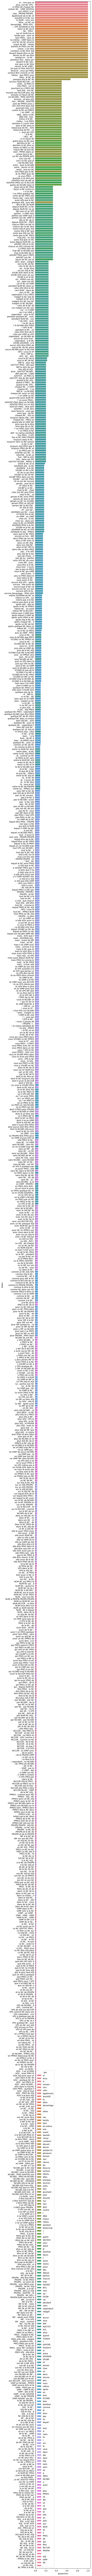

In [3]:
t1 = time.time()
# Transform to n_grams
pipeline.transform_to_ngrams(n)
t2 = time.time()
print(f"Execution time: {t2 - t1:.4f} secs")
## Number of tokens per document
sns.countplot(pipeline.ngrams, x="doc")
plt.title("Number of tokens per document")

# Plot distribution of tokens
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="group")

# Compute features

In this example, we use tfidf features and we plot the most frequent ones

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


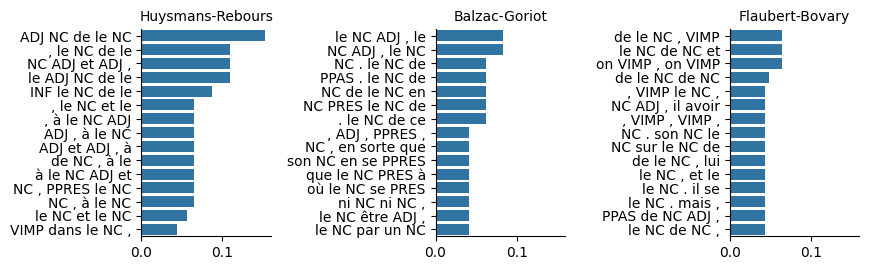

In [4]:
tfidf = pipeline.get_features(feature)
plot_tf_idf(tfidf, n_tokens=15, plot_type="sep")

# Principal Component Analysis


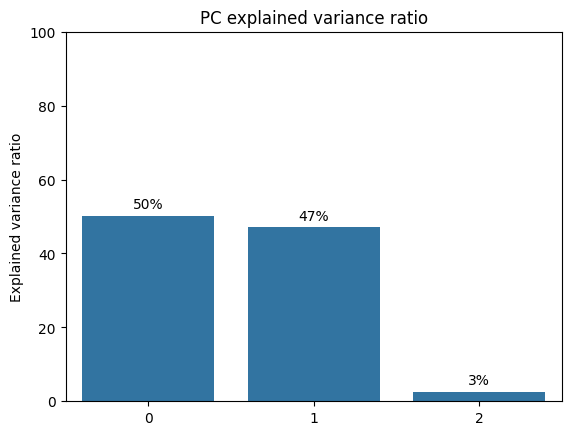

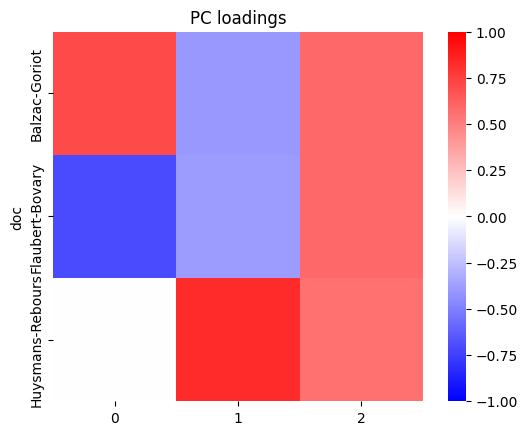

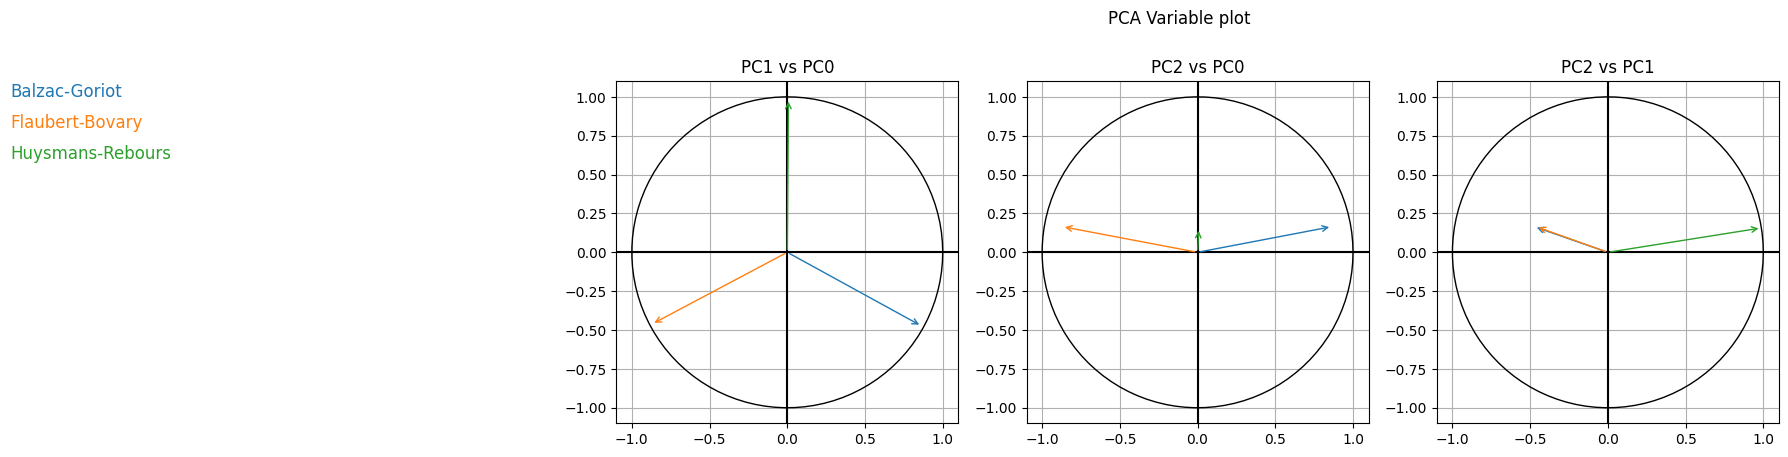

In [5]:
pca = pca_transform(
    tfidf.pivot_table(
        index="token", columns=["doc"], values=feature["name"]
    ), 
    plot=True
)

- We observe that the first two principal components (PC) explains 97% of the variance:
    - the first component explains both Flaubert-Bovary and Balzac-Goriot, but not Huysmans-Rebours
    - the second one explains very well Huysmans-Rebours
- Balzac-Goriot is positively correlated with the first PC
- Flaubert-Bovary is negatively correlated with the first PC
- Huysmans-Rebours is positvely correated with the second PC.
- We can say the first can be used to separate Flaubert-Bovary from Balzac-Goriot, while the second PC can be used to separate Huysmans-Rebours from Flaubert-Bovary and Balzac-Goriot.

# We can also execute the featurization and PCA in one call

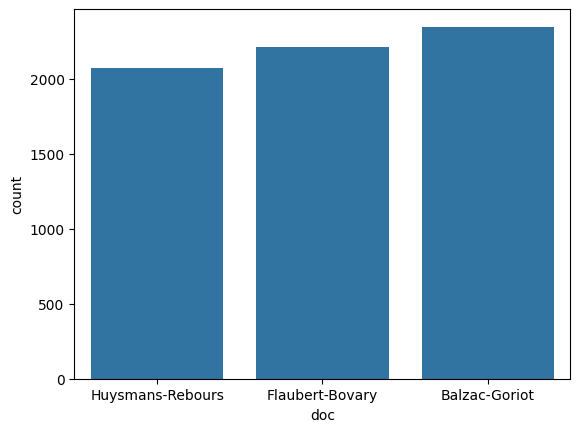

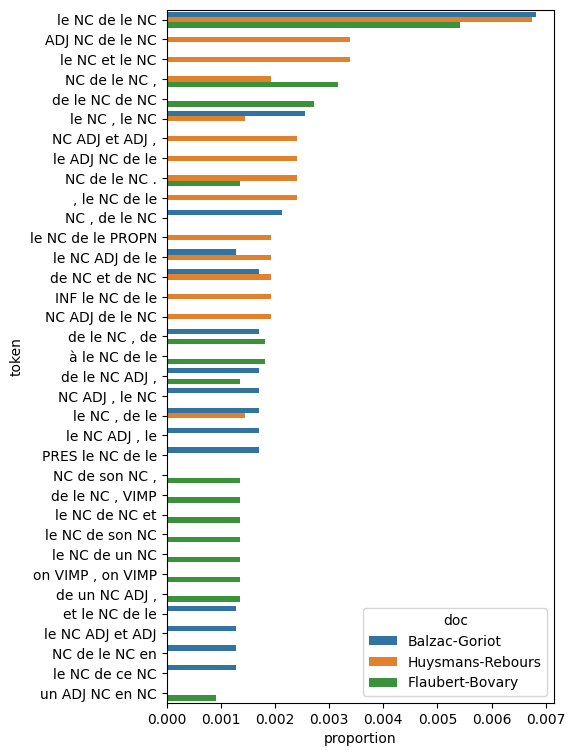

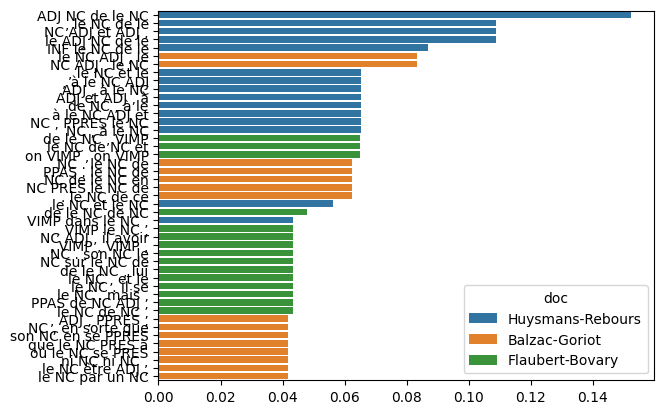

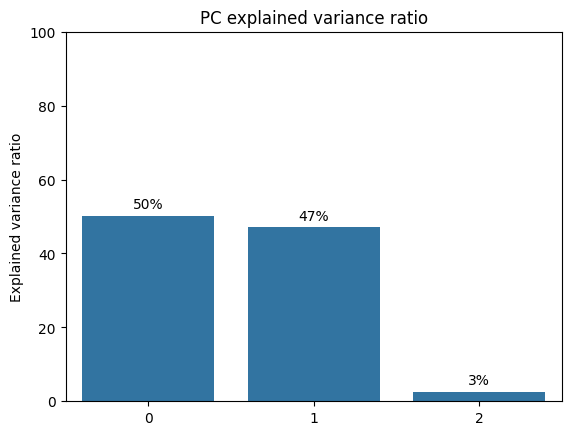

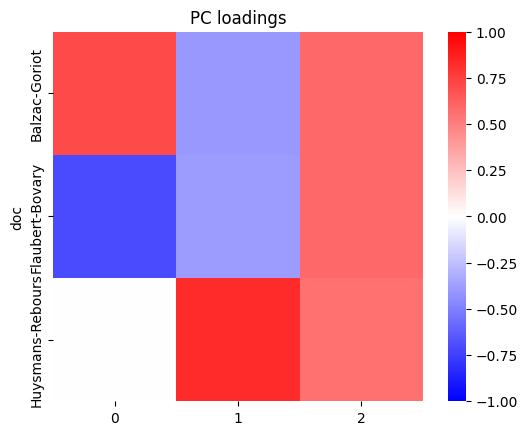

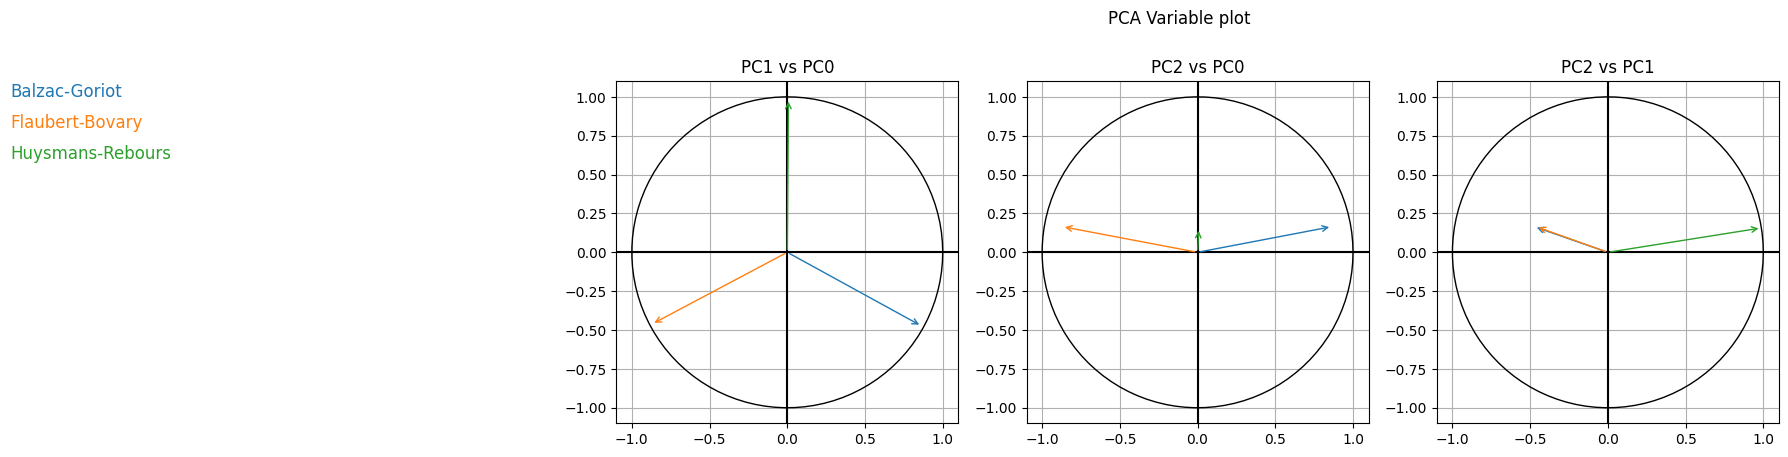

In [6]:
pipeline.execute(n=5, feature=feature, method="pca", plot=True, stat="proportion", n_tokens=15, plot_type="group")

# Specificity

In [7]:
from motifs.features import build_specificity
spec = build_specificity(pipeline.ngrams)

In [8]:
# Show the 10 most specific tokens for Balzac-Goriot:
doc = "Balzac-Goriot"
spec.sort_values(by=[doc, "spec"], ascending=False).head(10)

,Balzac-Goriot,Flaubert-Bovary,Huysmans-Rebours,doc,f,t,spec,rel_f
token,,,,,,,,
"NC ADJ , le NC",1.804765,0.000000,0.000000,Balzac-Goriot,4,2348,1.804765,0.001704
"le NC ADJ , le",1.804765,0.000000,0.000000,Balzac-Goriot,4,2348,1.804765,0.001704
. le NC de ce,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC . le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC PRES le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
NC de le NC en,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
PPAS . le NC de,1.353394,0.000000,0.000000,Balzac-Goriot,3,2348,1.353394,0.001278
PRES le NC de le,1.250202,-0.881275,0.000000,Balzac-Goriot,4,2348,1.250202,0.001704
PRES le NC de le,1.250202,-0.881275,0.000000,Flaubert-Bovary,1,2212,-0.881275,0.000452


It seems that in Goriot, Balzac often starts a sentence with "le NC de". This motif is highly specific to Balzac-Goriot with an index of 2.41 and appearing 7 times. It is under-represented in Huysmans-Rebours with a negative specificity of -1.3, appearing only once. It is not represented in Flaubert-Bovary.

# Top down analysis


We have identified a very specific motif ". le NC de" in Balzac-Goriot. Let us understand patterns in the original texts around this motif.

## Cooccurrence

First, it is important to check which motifs occur with the selected motif.

The analysis of cooccurrence is done at a context level. Thus we must transform the n-grams text into windows of n-grams of arbitrary length. For this, we use the `build_window_corpus`. For example, we can set the context length to 2 to check the immediate coocurrence (left and right).

Then we find the cooccurrent tokens with `find_cooccurrent_token`.

In [9]:
# Transform to context data frame
from motifs.utils import build_window_corpus
from motifs.metrics import find_cooccurrent_tokens

windows = build_window_corpus(pipeline.ngrams, 3)

# Within a single text
token = "NC ADJ , le NC"
tokens = find_cooccurrent_tokens(
    token, windows[windows.doc == doc], 30
)
tokens

,target,token,count
0,"NC ADJ , le NC","le NC ADJ , le",3


We observe that the most cooccurrent token of ". le NC de" is "NC de ce NC" that is we find that ". le NC de ce NC" seems to be an important motif in Balzac-Goriot. Balzac often starts sentences with "le NC de ce NC" in Goriot.

We can also check the cooccurrence of the motif at the corpus level without filtering, using `corpus_cooccurrent_tokens`

In [10]:
# At the corpus level
from motifs.metrics import corpus_cooccurrent_tokens
cooccurent_tokens = corpus_cooccurrent_tokens(token, windows, 10)
cooccurent_tokens

,target,token,count,doc
0,"NC ADJ , le NC","le NC ADJ , le",3,Balzac-Goriot


## Return-to-text

It is worth looking into the original text to understand how the motif is used.

For this we use the `return_to_text_from_token` function with a context length of 5 tokens, as it follows:

In [11]:
from motifs.utils import return_to_text_from_token
context_len = 5
context = return_to_text_from_token(pipeline.ngrams, token, n, context_len)
context

,left_context,text,right_context,doc,token
0,doit être . À la,"nuit tombante , la porte",à claire-voie est remplacée par,Balzac-Goriot,"NC ADJ , le NC"
1,le mur mitoyen de la,"maison voisine , le long",de laquelle pend un manteau,Balzac-Goriot,"NC ADJ , le NC"
2,". La , durant les","jours caniculaires , les convives",assez riches pour se permettre,Balzac-Goriot,"NC ADJ , le NC"
3,à l' exploitation de la,"pension bourgeoise , le rez-de-chaussée",se compose d' une première,Balzac-Goriot,"NC ADJ , le NC"


# Bottom up analysis

## Cooccurrence

For example, we can find the top $n$ coocurrent motif within a single document like Balzac-Goriot with `find_top_n_cooccurrence`. We use $n=5$ in the example below:

In [12]:
# Within a single text
from motifs.metrics import find_top_n_cooccurrence
cooc = find_top_n_cooccurrence(windows[windows.doc == doc], 5)
cooc

,token1,token2,count
0,"ADJ , de le NC","NC ADJ , de le",2
1,. le NC de le,le NC de le NC,2
2,", le NC , le","le NC , le NC",2
3,"de le NC , de","le NC , de le",3
4,"NC ADJ , le NC","le NC ADJ , le",3


## Specificity

For example, we can check the original text for the most specific tokens in the corpus with the function `return_to_text_from_spec`. To only return a reasonable number of tokens, we apply a filter on the tokens. We return the tokens that have a minimum specificity of 1 (`min_spec=1`) and a minimum frequency of 2 (`min_freq=2`, default behavior).

In [13]:
from motifs.utils import return_to_text_from_spec
import time
t1 = time.time()
context = return_to_text_from_spec(pipeline.ngrams, spec, n, context_len, min_spec=1, min_freq=2)
t2 = time.time()
print(t2-t1)
context

0.16578292846679688


,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
ADJ NC de le NC,l' arc bombé remplissait l',énorme coquille de les cuirasses,. Ceux -là étaient les,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,l' un de les plus,intimes familiers de le duc,d' Épernon et de le,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,efforça de lui apprendre les,premiers éléments de les sciences,. Sa famille se préoccupait,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,la nuit factice dont les,épais rideaux de les croisées,enveloppaient la chambre . Les,Huysmans-Rebours,3.538804,7,2073
ADJ NC de le NC,à le diriger sur les,profitables carrières de les écoles,; bien qu' il discutât,Huysmans-Rebours,3.538804,7,2073
...,...,...,...,...,...,...,...
"le NC , le NC",voir le vernis écaillé qui,"la couvre , les amateurs",de symboles y découvriraient peut-être,Balzac-Goriot,-1.763371,1,2212
"le NC , le NC",de pension . Elle sent,"le renfermé , le moisi",", le rance ; elle",Balzac-Goriot,-1.763371,1,2212
"le NC , le NC","Elle sent le renfermé ,","le moisi , le rance","; elle donne froid ,",Balzac-Goriot,-1.763371,1,2212
